In [49]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
from scipy.sparse import csr_matrix
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
data = pd.read_csv("scopus.csv")
data.head()

,Авторы,Идентификатор автора(ов),Название,Год,Название источника,Том,Выпуск,Статья №,Страница начала,Страница окончания,...,ISBN,CODEN,Идентификатор PubMed,Язык оригинального документа,Сокращенное название источника,Тип документа,Стадия публикации,Open Access (открытый доступ),Источник,EID
0,Nwedu C.N.,57215066934;,The rise of force majeure amid coronavirus pan...,2021,Natural Resources Journal,61,1,NaN,1,19,...,NaN,NaN,NaN,English,Nat. Resour. J.,Article,Final,NaN,Scopus,2-s2.0-85101852805
1,"Krzastek S.C., Farhi J., Gray M., Smith R.P.",57191912983;57221372581;57216597223;57212994756;,Impact of environmental toxin exposure on male...,2021,Translational Andrology and Urology,9,6,NaN,2797,2813,...,NaN,NaN,NaN,English,Transl. Androl. Urol.,Review,Final,"All Open Access, Gold, Green",Scopus,2-s2.0-85098965974
2,"Azimi-Yancheshmeh R., Moeinaddini M., Feiznia ...",57224217734;35362551800;25639512200;5468495040...,Seasonal and spatial variations in atmospheric...,2021,Sustainable Cities and Society,72,NaN,103020,NaN,NaN,...,NaN,NaN,NaN,English,Sustainable Cities Soc.,Article,Final,NaN,Scopus,2-s2.0-85107315439
3,"Kong W., Lv B., Yang S., Shen H., Jing G., Zho...",57224101163;56529025600;57224107656;5601737390...,Case study on environmental safety and sustain...,2021,Journal of Environmental Chemical Engineering,9,4,105734,NaN,NaN,...,NaN,NaN,NaN,English,J. Environ. Chem. Eng.,Article,Final,NaN,Scopus,2-s2.0-85106967424
4,"Kouis P., Psistaki K., Giallouros G., Michanik...",55839831200;57211682852;57199732189;5722238460...,Heat-related mortality under climate change an...,2021,Environmental Research,199,NaN,111285,NaN,NaN,...,NaN,ENVRA,34015294.0,English,Environ. Res.,Article,Final,NaN,Scopus,2-s2.0-85106926316


In [18]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [3]:
description = data['Краткое описание'].dropna().apply(lambda x: x.lower()).values

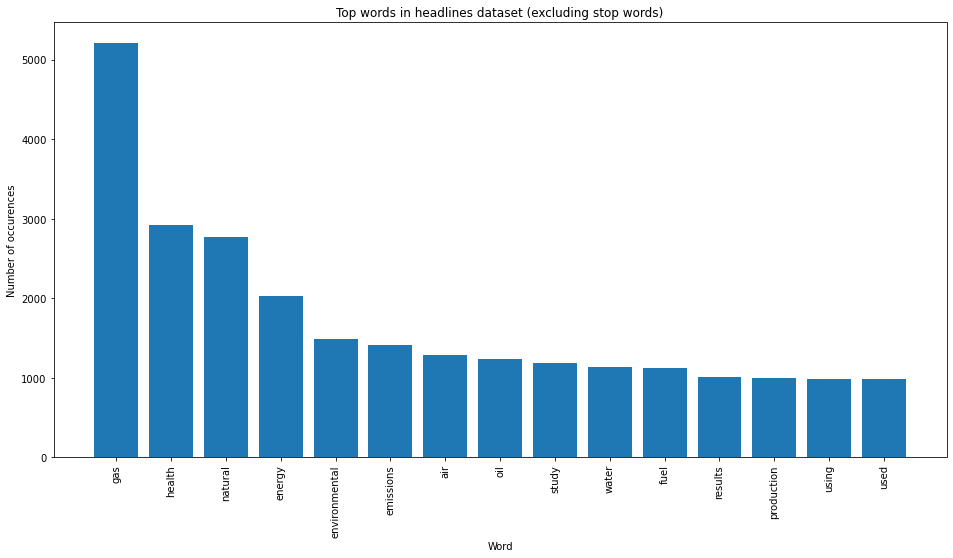

In [7]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=description)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [9]:
tagged_headlines = [TextBlob(description[i]).pos_tags for i in range(len(description))]

In [10]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  507275
Mean number of words per headline:  253.6375


In [88]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
document_term_matrix = count_vectorizer.fit_transform(description)

In [110]:
n_topics = 4

In [111]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [112]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [113]:
lsa_counts

[1907, 75, 18]

In [114]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        
        if type(i) == int:
            temp_vector_sum = csr_matrix((1, document_term_matrix.shape[1]))
                
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
        
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)
        top_words.append("; ".join(topic_words))         
    return top_words

In [115]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  іi; eisenia; eif
Topic 2:  іi; eisenia; eif
Topic 3:  іi; eisenia; eif
Topic 4:  іi; eisenia; eif
